In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polyfit import PolynomRegressor, Constraints

In [2]:
df63 = pd.read_excel('rack_63.xlsx', usecols=[2, 8, 11], names=['flowcell', 'slope', 'flow'])
df67 = pd.read_excel('rack_67.xlsx', usecols=[2, 8, 11], names=['flowcell', 'slope', 'flow'])

In [3]:
flowcells_63_1 = [
    105116,
    105179,
    105180,
    105189,
    105190,
    105217,
    105218,
    105219,
    105220,
    115074,
    115075,
    115076,
    115077,
    115078,
    115082,
    115083,
    115084,
    115085,
    115086,
    115087,
]

flowcells_63_2 = [
    105152,
    105207,
    105211,
    105229,
    105238,
    105253,
    105263,
    105264,
    105272,
    105281,
    105283,
    105296,
    105509,
    105510,
    105513,
    105514,
    105547,
    105548,
    105565,
    105566,
]

flowcells_67_1 = [
    115002,
    115003,
    115004,
    115005,
    115006,
    115007,
    115008,
    115066,
    115067,
    115068,
    115069,
    115070,
    115071,
    115072,
    115080,
    115081,
    115205,
    115222,
    115223,
    115224,
]

flowcells_67_2 = [
    105212,
    105268,
    115203,
    115204,
    115206,
    115207,
    115208,
    115209,
    115210,
    115211,
    115212,
    115213,
    115214,
    115215,
    115216,
    115217,
    115218,
    115219,
    115220,
    115221,
]

flowcells_63 = sorted(flowcells_63_1 + flowcells_63_2)
flowcells_67 = sorted(flowcells_67_1 + flowcells_67_2)

In [4]:
def get_flowcell_ids(df):
    return sorted(list(set(df['flowcell'])))

In [5]:
# Remove flowcells that are not installed
df63_to_remove = set(get_flowcell_ids(df63)) - set(flowcells_63)
df67_to_remove = set(get_flowcell_ids(df67)) - set(flowcells_67)
df63 = df63[~df63['flowcell'].isin(df63_to_remove)]
df67 = df67[~df67['flowcell'].isin(df67_to_remove)]

In [6]:
def get_artifical_point(slopes, flows, flow_desired):
    flow1, flow2 = sorted(list(set(flows)))[-2:]
    assert flow1 < flow_desired
    assert flow2 < flow_desired
    slopes1 = []
    slopes2 = []
    for flow, slope in zip(flows, slopes):
        if flow == flow1:
            slopes1.append(slope)
        if flow == flow2:
            slopes2.append(slope)
    slope1 = np.mean(slopes1)
    slope2 = np.mean(slopes2)
    slope_desired_flow = slope1 + (slope2-slope1)/(flow2-flow1)*(flow_desired-flow1)
    return slope_desired_flow, flow_desired

def add_point_for_flow(slopes, flows, flow_to_add):
    slope_new, flow_new = get_artifical_point(slopes, flows, flow_to_add)
    slopes.append(slope_new)
    flows.append(flow_new)

[-1.99905615e+01  1.76761720e-01 -7.36021018e-05  9.88353510e-09
 -4.03967419e-13]


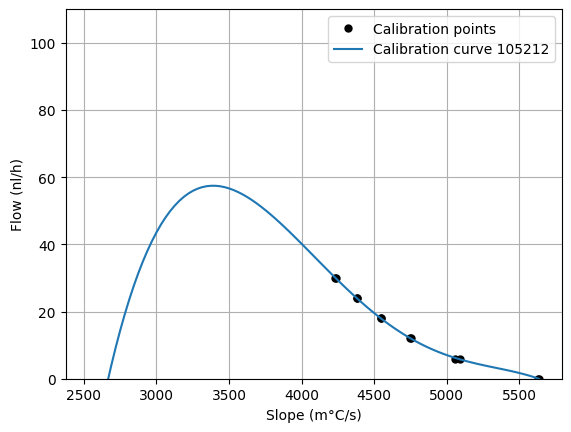

In [36]:
DEG = 4
df = pd.concat([df63, df67])

for i, flowcell in enumerate(get_flowcell_ids(df)):
    if i not in [8]:
        continue
    df_flowcell = df[(df['flowcell']==flowcell)]
    
    params_baseline = np.polynomial.polynomial.polyfit(df_flowcell['slope'], df_flowcell['flow'], 4)
    
    slopes = list(df_flowcell['slope'])
    flows = list(df_flowcell['flow'])
    flows_copy = list(flows)
    
    add_point_for_flow(slopes, flows, 60)
    add_point_for_flow(slopes, flows, 95)
    add_point_for_flow(slopes, flows, 100)
    
    polyestimator = PolynomRegressor(deg=DEG)
    monotone_constraint = Constraints(monotonicity='dec')
    X = np.array(slopes).reshape((-1,1))
    y = np.array(flows)
    polyestimator.fit(X, y, loss = 'l2', constraints={0: monotone_constraint})
    print(polyestimator.coeffs_)
    
    xx_plot = np.linspace(min(slopes), max(slopes), 100)
    yy_plot = polyestimator.predict(xx_plot.reshape(-1, 1))
    yy_baseline = [np.dot(params_baseline, [1, x, x**2, x**3, x**4]) for x in xx_plot]
    
    # plt.title(f'Flowcell {flowcell}')
    # plt.plot(slopes, flows, '.', markersize='10')
    plt.plot(slopes[:len(flows_copy)], flows_copy, 'k.', markersize='10', label='Calibration points')
    plt.plot(xx_plot, yy_baseline, label=f'Calibration curve {flowcell}')
    # plt.plot(xx_plot, yy_plot, label='New calibration')
    plt.ylim(0, 110)
    plt.xlabel('Slope (m°C/s)')
    plt.ylabel('Flow (nl/h)')
plt.legend()
plt.grid()
plt.show()